In [1]:
import imp
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import h5py

import util
from plot_core import PlotAx, STYLE_PATH
from util import *
from plot_model_training import *

%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

/home/cali/bin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers

Using TensorFlow backend.


In [3]:
style_file = os.path.join(STYLE_PATH, 'plot_regression.mplstyle')
plt.style.use(style_file)

In [4]:
in_dir = '/home/cali/data/GapFilling/CRISFull_validate/'
pic_dir = 'Picture'
result_dir = 'Result'
data_dir = 'Data'
model_dir = 'Model'
for _dir in [pic_dir, result_dir, data_dir, model_dir]:
    if not os.path.isdir(_dir):
        os.makedirs(_dir)
    print(_dir)

Picture
Result
Data
Model


# 合成全部的CRIS_full数据

In [5]:
filenames = os.listdir(in_dir)
in_files = [os.path.join(in_dir, filename) for filename in filenames]
in_files.sort()

cris_full_data_file = os.path.join(data_dir, 'CRIS_full_data_validate.hdf')
if not os.path.isfile(cris_full_data_file):
    combine_cris_full_data(in_files, cris_full_data_file)

# 加载全部波段数据

In [6]:
X_all, Y_all = load_cris_full_combine_data(cris_full_data_file, None)

(275881, 2211) (275881, 1158)


In [7]:
print(type(X_all))
print(type(Y_all))

print(X_all.shape)
print(Y_all.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(275881, 2211)
(275881, 1158)


In [8]:
# 判断是否有小于0和等于nan的无效值
print(np.where(X_all<=0)[0].shape)
print(np.where(Y_all<=0)[0].shape)

print(np.where(np.isnan(X_all))[0].shape)
print(np.where(np.isnan(Y_all))[0].shape)

print(np.where(X_all<=0)[0].shape)
print(np.where(Y_all<=0)[0].shape)

print(np.where(np.isnan(X_all))[0].shape)
print(np.where(np.isnan(Y_all))[0].shape)

(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)


# 加载预测波段的数据

In [9]:
# 所有测量通道和预测通道每一波段的范围和分辨率 (start, end, frequency)
ranges_X_all = [(650., 1095., 0.625), (1210., 1750., 0.625), (2155., 2550., 0.625), ]
ranges_Y_all = [(1095.625, 1209.375, 0.625), (1750.625, 2154.375, 0.625), (2550.625, 2755., 0.625), ]

# 当前测量通道和预测通道每一波段的范围和分辨率 (start, end, frequency)
ranges_X = ranges_X_all
# ranges_X = [(650., 1095, 0.625), ]
# ranges_X = [(1210., 1750, 0.625), ]
# ranges_X = [(2155., 2550., 0.625), ]
ranges_Y = ranges_Y_all
# ranges_Y = [(1095.625, 1209.375, 0.625), ]
# ranges_Y = [(1750.625, 2154.375, 0.625), ]
# ranges_Y = [(2550.625, 2755., 0.625), ]

In [10]:
if ranges_X != ranges_X_all:
    test_X = get_data_by_wavenumber_range(X_all, wavenumber_X_all, ranges_X)
else:
    test_X = X_all

if ranges_Y != ranges_Y_all:
    Y = get_data_by_wavenumber_range(Y_all, wavenumber_Y_all, ranges_Y)
else:
    test_Y = Y_all

In [11]:
wavenumber_X_all = get_wavenumber_by_range(ranges_X_all)
wavenumber_Y_all = get_wavenumber_by_range(ranges_Y_all)

wavenumber_X = get_wavenumber_by_range(ranges_X)
wavenumber_Y = get_wavenumber_by_range(ranges_Y)

index_X = get_range_index_by_range(ranges_X)
index_Y = get_range_index_by_range(ranges_Y)

print(index_X)
print(index_Y)

[[   0  713]
 [ 713 1578]
 [1578 2211]]
[[   0  183]
 [ 183  830]
 [ 830 1158]]


In [12]:
print(type(test_X))
print(type(test_Y))
print(type(wavenumber_X))
print(type(wavenumber_Y))
print(type(index_X))
print(type(index_Y))

print(test_X.shape)
print(test_Y.shape)
print(wavenumber_X.shape)
print(wavenumber_Y.shape)
print(index_X.shape)
print(index_Y.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(275881, 2211)
(275881, 1158)
(2211,)
(1158,)
(3, 2)
(3, 2)


In [13]:
print(np.where(test_X<=0)[0].shape)
print(np.where(test_Y<=0)[0].shape)

print(np.where(np.isnan(test_X))[0].shape)
print(np.where(np.isnan(test_Y))[0].shape)

(0,)
(0,)
(0,)
(0,)


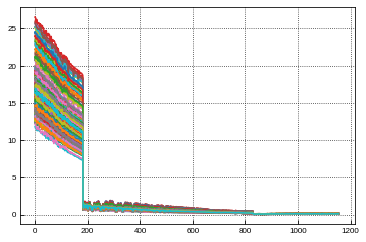

In [14]:
for i in range(500, 1000):
    plt.plot(test_Y[i])

In [15]:
def get_predict_data_by_linear_model(test_X, linear_model_attribute_business):
    """
    通过线性模型的模型系数获取预测值
    """
    lin_reg = LinearRegression()
    coef, intercept = get_linear_model_attributes(linear_model_attribute_business)
    lin_reg.coef_ = coef.T
    lin_reg.intercept_ = intercept.T
    predict_Y_linear = lin_reg.predict(test_X)

    mae = mean_absolute_error(test_Y, predict_Y_linear)
    mse = mean_squared_error(test_Y, predict_Y_linear)
    print('MAE: ', mae)
    print('MSE: ', mse)

    return predict_Y_linear

In [16]:
def get_valid_data(test_X, test_Y, predict_Y_linear):
    """
    通过预测的数据获取剔除无效值的真值数据和预测数据
    """
    index = predict_Y_linear <= 0
    if not index.any():  # 如果预测数据的所有数据都是有效值，直接返回原来的结果
        print('all data is valid')
        return test_X, test_Y, predict_Y_linear
    else:
        # 去除预测结果中含无效值（<=0）的光谱
        test_X_linear_tmp = test_X.copy()
        test_Y_linear_tmp = test_Y.copy()
        predict_Y_linear_tmp = predict_Y_linear.copy()

        test_X_linear_tmp = pd.DataFrame(test_X_linear_tmp)
        test_Y_linear_tmp = pd.DataFrame(test_Y_linear_tmp)
        predict_Y_linear_tmp = pd.DataFrame(predict_Y_linear_tmp)
        print(test_X_linear_tmp.shape)
        print(test_Y_linear_tmp.shape)
        print(predict_Y_linear_tmp.shape)

        index = predict_Y_linear_tmp <= 0

        test_X_linear_tmp[index] = np.nan
        test_Y_linear_tmp[index] = np.nan
        predict_Y_linear_tmp[index] = np.nan

        test_X_linear_tmp = test_X_linear_tmp.dropna(axis=0)
        predict_Y_linear_tmp = predict_Y_linear_tmp.dropna(axis=0)
        test_Y_linear_tmp = test_Y_linear_tmp.dropna(axis=0)
        print(test_X_linear_tmp.shape)
        print(test_Y_linear_tmp.shape)
        print(predict_Y_linear_tmp.shape)

        test_X_linear_tmp = np.array(test_X_linear_tmp)
        test_Y_linear_tmp = np.array(test_Y_linear_tmp)
        predict_Y_linear_tmp = np.array(predict_Y_linear_tmp)

        return test_X_linear_tmp, test_Y_linear_tmp, predict_Y_linear_tmp

In [17]:
def get_predict_data(test_X, test_Y, model_name):
    # 得到预测结果和预测的TBB
    linear_model_attribute_file_business = os.path.join(model_dir, 'linear_model_attribute_{}.h5'.format(model_name))
    print(linear_model_attribute_file_business)
    predict_Y_business = get_predict_data_by_linear_model(test_X, linear_model_attribute_file_business)
    test_X_tmp_business, test_Y_tmp_business, predict_Y_tmp_business = get_valid_data(test_X, test_Y, predict_Y_business)

    test_X_tbb_business = rad2tbb(test_X_tmp_business, wavenumber_X)
    test_Y_tbb_business = rad2tbb(test_Y_tmp_business, wavenumber_Y)
    predict_Y_tbb_business = rad2tbb(predict_Y_tmp_business, wavenumber_Y)

    # 预测结果的偏差绘图
    out_filename_business = '0000_' + '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i]) + '_{}.png'.format(model_name)
    

    out_file_business = os.path.join(validate_dir, out_filename_business)

    plot_model_validate(test_Y_tbb_business, predict_Y_tbb_business, wavenumber_Y, index_Y, out_file_business)
    
    return rad2tbb(predict_Y_business, wavenumber_Y)

In [37]:
def plot_validate_picture(test_X_tbb_linear, test_Y_tbb_linear, predict_Y_tbb_linear, model_name, number):
    file_name = os.path.join(validate_dir, 's_{:04d}_{:02d}_{}.png')

    alpha = 0.7
    figsize1 = (6.4, 2.5)
    figsize2 = (6.4, 1.5)

    for data_number in range(0, number):
        count = 0
        fig = plt.figure(figsize=figsize1, dpi=150)
        plot_true_label = False
        plot_predict_label = False
        for s, e in index_X:
            plt.plot(wavenumber_X[s: e], test_X_tbb_linear[data_number][s: e], c='b', alpha=alpha)
        for s, e in index_Y:
            if plot_true_label:
                label=None
            else:
                label='true'
            plt.plot(wavenumber_Y[s: e], test_Y_tbb_linear[data_number][s: e], c='b', alpha=alpha, label=label)
            plot_true_label = True
        for s, e in index_Y:
            if plot_predict_label:
                label=None
            else:
                label='predict'
            plt.plot(wavenumber_Y[s: e], test_Y_tbb_linear[data_number][s: e], c='r', alpha=alpha, label=label)
            plot_predict_label = True
        plt.xlabel('Wavenumber($cm^{-1}$)')
        plt.ylabel('TBB ($K$)')
        plt.legend()
        plt.show()
        fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
        print(file_name.format(data_number, count, model_name))
        count += 1

        fig = plt.figure(figsize=figsize2, dpi=150)
        for s, e in index_Y:
            tbb_bias = predict_Y_tbb_linear[data_number][s: e] - test_Y_tbb_linear[data_number][s: e]
            plt.scatter(wavenumber_Y[s: e], tbb_bias, s=0.1)
            plt.xlabel('Wavenumber($cm^{-1}$)')
            plt.ylabel('TBB Bias($K$)')
        plt.show()
        fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
        print(file_name.format(data_number, count, model_name))
        count += 1

        for s, e in index_Y:
            fig = plt.figure(figsize=figsize1, dpi=150)
            plt.plot(wavenumber_Y[s: e], test_Y_tbb_linear[data_number][s: e], c='b', alpha=alpha, label='true')
            plt.plot(wavenumber_Y[s: e], predict_Y_tbb_linear[data_number][s: e], c='r', alpha=alpha, label='predict')
            plt.xlabel('Wavenumber($cm^{-1}$)')
            plt.ylabel('TBB ($K$)')
            plt.legend()
            plt.show()
            fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
            print(file_name.format(data_number, count, model_name))
            count += 1

In [43]:
def plot_model_validate(tbb_test, tbb_predict, wavenumber, index, out_file):
    """
    对模型结果进行验证
    """
    bias = tbb_predict - tbb_test

    fig = plt.figure(figsize=(6.4, 4), dpi=120)
    ax1 = plt.subplot2grid((3, 1), (0, 0))
    ax2 = plt.subplot2grid((3, 1), (1, 0), sharex=ax1)
    ax3 = plt.subplot2grid((3, 1), (2, 0), sharex=ax1)

    lw = 1

    rows = bias.shape[0]
    wavenumbers = np.tile(wavenumber, [rows, 1])

    for s, d in index:
        ax1.plot(wavenumber[s:d], bias.mean(axis=0)[s:d], lw=lw)
        ax1.set_ylim(-3, 3)
        ax1.set_ylabel('TBB Bias Mean $(K)$')
        ax2.plot(wavenumber[s:d], bias.std(axis=0)[s:d], lw=lw)
        ax2.set_ylim(0.0, 4)   
        ax2.set_ylabel('TBB Bias Std $(K)$')

        ax3.scatter(wavenumbers[:20000, s:d], bias[:20000, s:d], s=0.1)
        ax3.set_ylim(-25, 25)
        ax3.set_ylabel('TBB Bias $(K)$')
        ax3.set_xlabel('Wavenumber $(cm^{-1})$')

    # ##### 保存图片
    fig.savefig(out_file, dpi=100)
    plt.show()
    fig.clear()
    plt.close()
    print('>>> {}'.format(out_file))

In [64]:
def add_annotate(ax, strlist, local, color="#000000", fontsize=11, font=None):
    """
    添加上方注释文字
    loc must be "left_top" or "right_top"
    or "left_bottom" or "right_bottom"
    格式 ["annotate1", "annotate2"]
    """
    if strlist is None:
        return
    xticklocs = ax.xaxis.get_ticklocs()
    yticklocs = ax.yaxis.get_ticklocs()

    x_step = (xticklocs[1] - xticklocs[0])
    x_toedge = x_step / 6.
    y_toedge = (yticklocs[1] - yticklocs[0]) / 6.

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    if local == "left_top":
        ax.text(xlim[0] + x_toedge, ylim[1] - y_toedge,
                "\n".join(strlist), ha="left", va="top", color=color,
                fontsize=fontsize, zorder=100)

    elif local == "right_top":
        ax.text(xlim[1] - x_toedge, ylim[1] - y_toedge,
                "\n".join(strlist), ha="right", va="top", color=color,
                fontsize=fontsize, zorder=100)

    elif local == "left_bottom":
        ax.text(xlim[0] + x_toedge, ylim[0] + y_toedge,
                "\n".join(strlist), ha="left", va="bottom", color=color,
                fontsize=fontsize, zorder=100)
    elif local == "right_bottom":
        ax.text(xlim[1] - x_toedge, ylim[0] + y_toedge,
                "\n".join(strlist), ha="right", va="bottom", color=color,
                fontsize=fontsize, zorder=100)
    else:
        return

In [66]:
def plot_model_compare(tbb_predict1, tbb_predict2):
    """
    对模型结果进行验证
    """
    x_1 = tbb_predict1
    y_1 = tbb_predict2
    y_2 = y_1 - x_1

    lw = 1

    s_n = 0
    e_n = 20000
    plot_ax = PlotAx()
    
    fig = plt.figure(figsize=(13, 10), dpi=120)
    ax1_ = plt.subplot2grid((3, 3), (0, 0))
    ax2_ = plt.subplot2grid((3, 3), (0, 1))
    ax3_ = plt.subplot2grid((3, 3), (0, 2))
    ax4_ = plt.subplot2grid((3, 3), (1, 0))
    ax5_ = plt.subplot2grid((3, 3), (1, 1))
    ax6_ = plt.subplot2grid((3, 3), (1, 2))
    ax7_ = plt.subplot2grid((3, 3), (2, 0))
    ax8_ = plt.subplot2grid((3, 3), (2, 1))
    ax9_ = plt.subplot2grid((3, 3), (2, 2))
    
    for s_s, e_s, (ax1, ax2, ax3) in [(0, 183, (ax1_, ax2_, ax3_)), (183, 777, (ax4_, ax5_, ax6_)), (777, 1158, (ax7_, ax8_, ax9_))]:
        # 线性回归图
        x = x_1[s_n:e_n, s_s:e_s]
        y = y_1[s_n:e_n, s_s:e_s]
        ax1.scatter(x, y, s=0.1)
        ax1.set_xlabel('TBB ($K$) New')
        ax1.set_ylabel('TBB ($K$) Chen')
        ax1.set_xlim(210, 300)
        ax1.set_ylim(210, 300)

        # 回归线
        ab = np.polyfit(x.reshape(-1, ), y.reshape(-1, ), 1)
        a = ab[0]
        b = ab[1]
        x_min = np.nanmin(x)
        x_max = np.nanmax(x)
        ax1.plot([x_min, x_max], [x_min * a + b, x_max * a + b],
                color='r', linewidth=0.4, zorder=100)
        
        # 注释文字
        # 计算 rmse 平方根误差
        rmse = np.linalg.norm(x - y) / np.sqrt(len(x))
        # 计算相关性
        r = np.corrcoef(x, y)
        rr = r[0][1] * r[0][1]
        # 总数
        idx = np.where(np.isfinite(x))
        count = idx[0].size

        left_top = [r'$ y = {:0.4f}x+{:0.4f}$'.format(a, b),
                    r'R={:0.4f}'.format(rr),
                    r'$RMSE={:0.4f}$'.format(rmse),
                    r'$N={:d} $'.format(count)]
        add_annotate(ax1, left_top, 'left_top')

        # 偏差回归图
        x = x_1[s_n:e_n, s_s:e_s]
        y = y_2[s_n:e_n, s_s:e_s]
        ax2.scatter(x, y, s=0.1)
        ax2.set_xlabel('TBB ($K$) New')
        ax2.set_ylabel('TBB Bias($K$) Chen-New')
        ax2.set_xlim(210, 300)
    #     ax2.set_ylim(-3, 3)
        m = np.nanmean(y)
        
        left_top = ['Mean: {:0.4f}'.format(m)]
        add_annotate(ax2, left_top, 'left_top')

        count, bias = np.histogram(y_2[s_n:e_n, s_s:e_s], bins=1000, range=(-25, 25))
        ax3.set_xlabel('TBB ($K$) New')
        ax3.set_ylabel('Count')
        ax3.bar(bias[:-1], count)

        # ##### 保存图片
    plt.show()
#         fig.savefig(out_file, dpi=100)
#         fig.clear()
#         plt.close()
#         print('>>> {}'.format(out_file))

### 创建验证结果的文件

In [20]:
validate_dir = '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i]) + '_validate'
validate_dir = os.path.join(result_dir, validate_dir)
if not os.path.isdir(validate_dir):
    os.mkdir(validate_dir)
print(validate_dir)

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate


### 创建X的TBB

In [21]:
test_X_tbb = rad2tbb(test_X, wavenumber_X)
test_Y_tbb = rad2tbb(test_Y, wavenumber_Y)

### 业务模型参数预测

Model/linear_model_attribute_business.h5
MAE:  0.20274943
MSE:  0.2684876
all data is valid


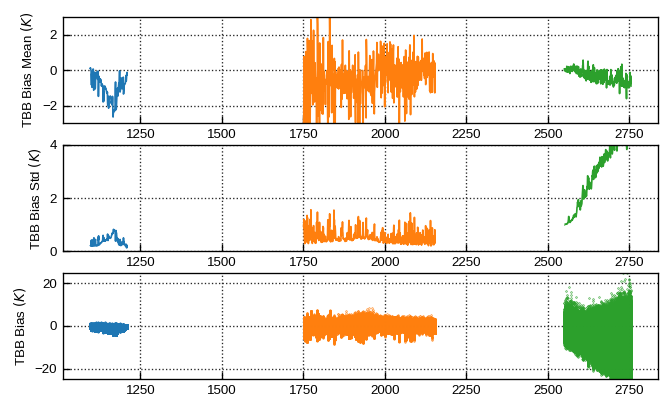

>>> Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/0000_650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_business.png


In [39]:
model_name = 'business'
predict_Y_tbb_business = get_predict_data(test_X, test_Y, model_name)

In [22]:
number = 0
plot_validate_picture(test_X_tbb, test_Y_tbb, predict_Y_tbb_business, model_name, number)

### 测试模型参数预测

Model/linear_model_attribute_test.h5
MAE:  0.029181927
MSE:  0.003589809
all data is valid


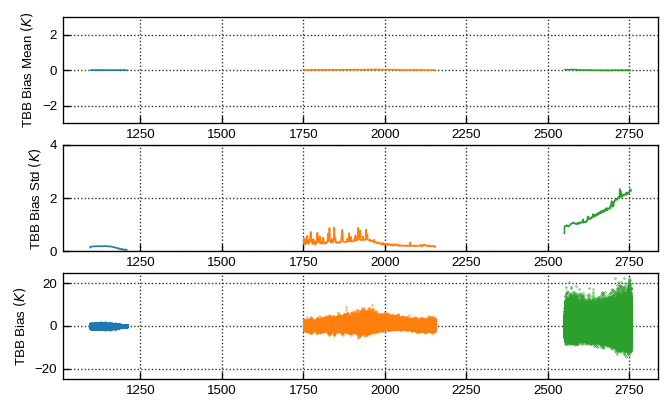

>>> Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/0000_650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_test.png


In [40]:
model_name = 'test'
predict_Y_tbb_test = get_predict_data(test_X, test_Y, model_name)

In [24]:
number = 0
plot_validate_picture(test_X_tbb, test_Y_tbb, predict_Y_tbb_test, model_name, number)

# 模型结果对比

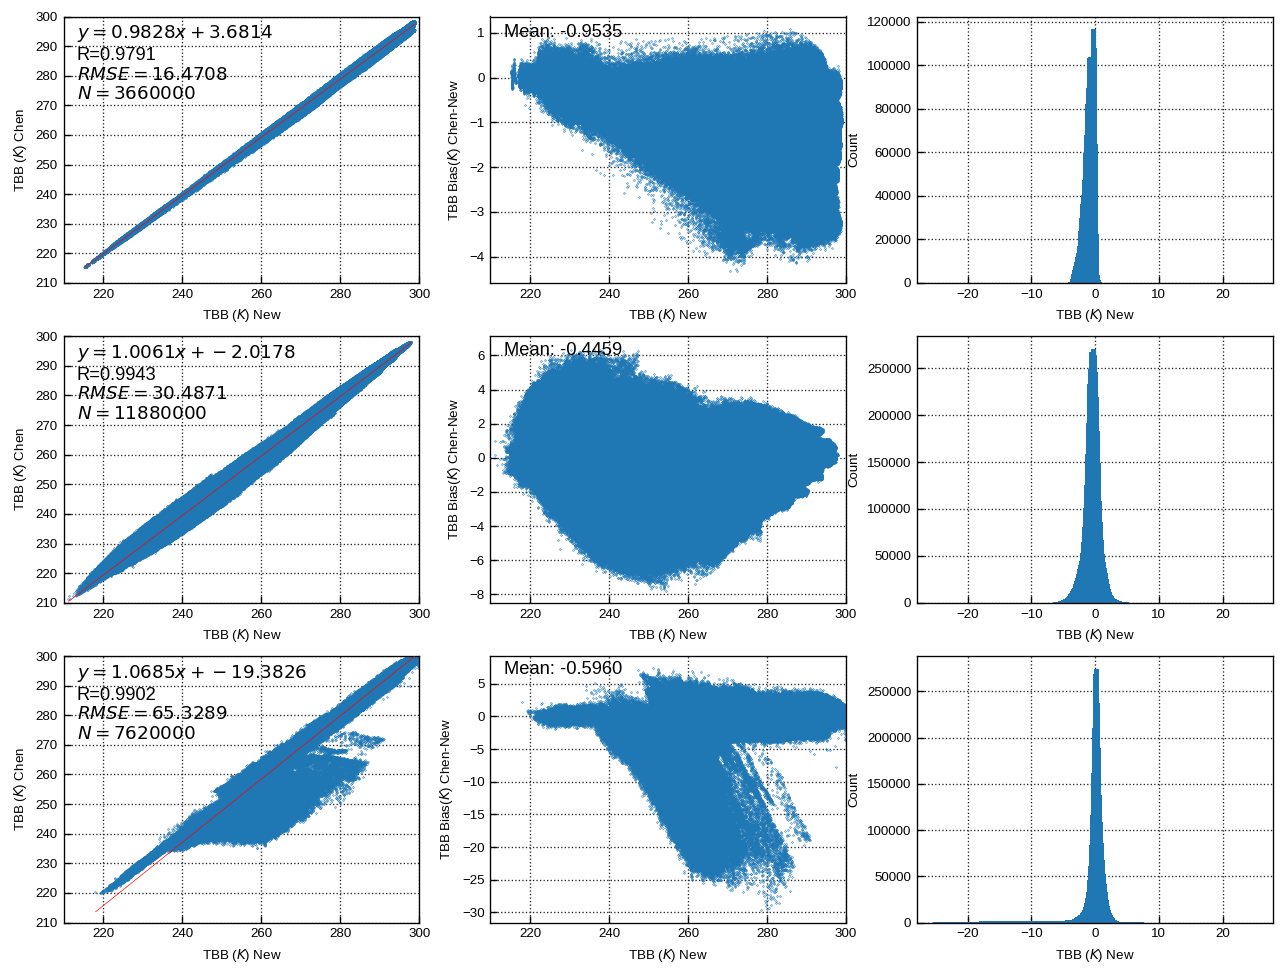

In [67]:
plot_model_compare(predict_Y_tbb_test, predict_Y_tbb_business)